# Prevendo o preço: Bitcoin e Ethereum

## Instalando a biblioteca com o banco de dados

In [0]:
!pip install kaggle

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


## Importando as bibliotecas

In [0]:
import requests
from pyspark.sql import functions as F, types as T
import pandas as pd

## Baixando os dados

In [0]:
!kaggle datasets download -d kapturovalexander/bitcoin-and-ethereum-prices-from-start-to-2023

Dataset URL: https://www.kaggle.com/datasets/kapturovalexander/bitcoin-and-ethereum-prices-from-start-to-2023
License(s): CC0-1.0
bitcoin-and-ethereum-prices-from-start-to-2023.zip: Skipping, found more recently modified local copy (use --force to force download)


## Extração do aquivo .zip

In [0]:
!unzip -o /databricks/driver/bitcoin-and-ethereum-prices-from-start-to-2023.zip

Archive:  /databricks/driver/bitcoin-and-ethereum-prices-from-start-to-2023.zip
  inflating: BTC-USD (2014-2024).csv  
  inflating: Bitcoin USD (01-05.2024).csv  
  inflating: ETH-USD (01-05.2024).csv  
  inflating: ETH-USD (2017-2024).csv  


## Tratamento das tabelas

In [0]:
tables = {
    df_btc: "file:/databricks/driver/BTC-USD (2014-2024).csv",
    df_btc_2024: "file:/databricks/driver/Bitcoin USD (01-05.2024).csv",
    df_etc: "file:/databricks/driver/ETH-USD (2017-2024).csv",
    df_etc_2024: "file:/databricks/driver/ETH-USD (01-05.2024).csv"
}

## Geração dos DataFrames
Está sendo dessa maneira para evitar um código muito repetitivo 

In [0]:
for df, table in tables.items():
    df = (
        spark.read.csv(table, header=True)
        .withColumn("Open", F.col("Open").cast(T.DoubleType()))
        .withColumn("High", F.col("High").cast(T.DoubleType()))
        .withColumn("Low", F.col("Low").cast(T.DoubleType()))
        .withColumn("Close", F.col("Close").cast(T.DoubleType()))
        .withColumn("Volume", F.col("Volume").cast(T.IntegerType()))
        .withColumn("Date", F.to_date(F.col("Date")))
        .drop("Adj Close")
    )

## Unindo as tabelas

In [0]:
df_btc_final = df_btc.union(df_btc_2024).toPandas().set_index('Date')
df_etc_final = df_etc.union(df_etc_2024).toPandas().set_index('Date')

<Axes: xlabel='Date'>

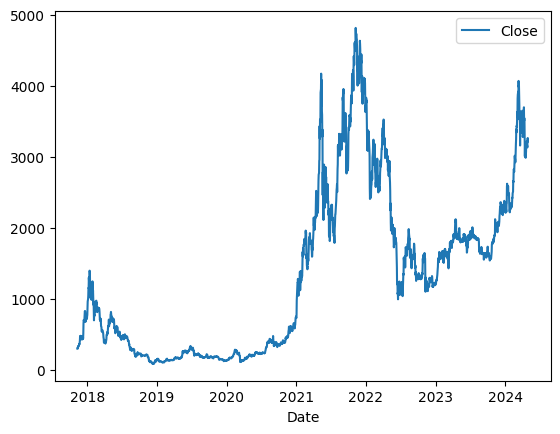

In [0]:
df_etc_final[['Close']].plot()